# Evolutionary Robot Path Planning

In [101]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

In [98]:
class Obstacle:

    def __init__(self, xlim: tuple, ylim: tuple, permeability=1, velocity=(0, 0)):
        self.xlim = np.array(xlim)
        self.ylim = np.array(ylim)
        self.permeability = permeability
        self.velocity = velocity

    def update_position(self):
        self.xlim += self.velocity[0]
        self.ylim += self.velocity[1]


In [ ]:
class Simulation:
    
    def __init__(self, size: tuple, start : tuple, objective: tuple, num_agents=10):
        self.size = size
        self.start = start
        self.objective = objective
        self.num_agents = num_agents

        # self.agents = 
        self.obstacles = []

    def run():
        # Create agents here?
        # Find optimal path
        pass
        
    def add_obstacles(self, *obstacles):
        self.obstacles.extend(obstacles)

    def draw_path(self, path):
        # Keeping this general for now - could take in the agent instead of the path in the future
        # Path format can also be changed

        # Setup figure and axis
        fig, ax = plt.subplots()
        fig.set_size_inches((7, 7))
        ax.set_xlim(0, self.size[0])
        ax.set_ylim(0, self.size[1])
        ax.set_axis_off()

        # Start and objective
        ax.plot(self.start[0], self.start[1], 'bX', markersize=7)
        ax.plot(self.objective[0], self.objective[1], 'r*', markersize=10)

        # Obstacles
        for obs in self.obstacles:
            ax.add_patch(patches.Rectangle((obs.xlim[0], obs.ylim[0]), obs.xlim[1] - obs.xlim[0], obs.ylim[1] - obs.ylim[0],
                                           color='black', alpha=obs.permeability))

        # Path
        for i, pos in enumerate(path[:-1]):
            next_pos = path[i+1]
            ax.plot((pos[0], next_pos[0]), (pos[1], next_pos[1]), 
                     linestyle='--', marker='.', color='black', mfc='blue', mec='blue', markersize=7)
            

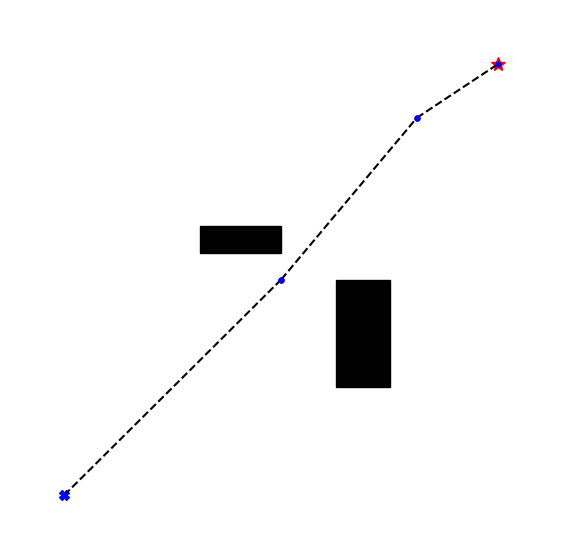

In [103]:
# Test
start = (10, 10)
objective = (90, 90)
sim = Simulation((100, 100), start, objective)
sim.add_obstacles(Obstacle((35, 50), (55, 60)), Obstacle((60, 70), (30, 50)))

sim.draw_path([start, (50, 50), (75, 80), objective])